In [5]:
# unit test
import unittest

import sys
sys.path.insert(0, r"helper")
sys.path.insert(0, r"/helper")
sys.path.insert(0, r"./helper")
sys.path.insert(0, r"../helper")
print(sys.path)

['../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


0.10836802322189582


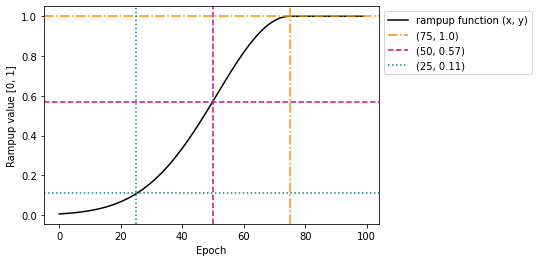

In [52]:
import numpy as np
import matplotlib.pyplot as plt

currents = range(0, 100)
rampup_length = 75

results = []
for current in currents:
    current = np.clip(current, 0.0, rampup_length)
    result = float(np.exp(-5.0 * (1.0 - current / rampup_length) ** 2))
    results.append(result)

print(results[25])
    
plt.figure()
plt.plot(currents, results, color = 'k', label = "rampup function (x, y)")
plt.xlabel("Epoch")
plt.ylabel("Rampup value [0, 1]")
plt.axvline(x = 75, color = 'darkorange', label = '(75, 1.0)', linestyle = '-.')
plt.axhline(y = 1, color = 'darkorange', linestyle = '-.')
plt.axvline(x = 50, color = 'mediumvioletred', label = '(50, 0.57)', linestyle = '--')
plt.axhline(y = 0.57, color = 'mediumvioletred', linestyle = '--')
plt.axvline(x = 25, color = 'teal', label = '(25, 0.11)', linestyle = ':')
plt.axhline(y = 0.11, color = 'teal', linestyle = ':')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.savefig("example_results/rampup.png", dpi=1200)


In [9]:
from dataset.meanteacher import *
from model.decentblock import *
from compute.metric.uncertainty import *

import torch
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

import glob



class UnitTestUncertainty(unittest.TestCase):   

        
    def test_metric(self):
        
        channels = 1
        n_output_neurons=2
        um = UncertaintyMetric(n_noise=4, n_repeat=2, n_output_neurons=n_output_neurons)

        model = smp.UnetPlusPlus(
                                encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                                encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
                                in_channels=channels,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                                classes=n_output_neurons,         # model output channels (number of classes in your dataset)
                            )

        csv_filenames = glob.glob(r"../data_prep/mt_*.csv")
        # image size has to be dividable by 32!!
        dataset = MeanTeacherTrainDataset(mode="train", channels=channels, image_size=512, csv_filenames=csv_filenames)
        train_loader = DataLoader(dataset, batch_size=3, shuffle=False)

        uncertainy_mask = None

        for idx, item in enumerate(train_loader):

            uncertainy_mask = um.run(model, item["img"])

            print(uncertainy_mask)

            plt.figure()
            plt.imshow( uncertainy_mask[0].permute(1, 2, 0), cmap="gray" )

            plt.figure()
            plt.imshow( uncertainy_mask[0].permute(1, 2, 0) < 0.68, cmap="gray" )

            break

    
    
    def test_dummy(self):
        
        # same code as in metric class, but with prints
        
        import torch

        #for image in batch:

        batch_size = 6
        width = 3
        height = 3
        n_copy = 2
        n_noise = 4
        output_neurons = 5
        input_channels = 1

        tmp_img = torch.rand(batch_size, input_channels, width, height) # 1 image, 2 probability outputs, 3x3 wxh
        print("action: dummy batch")
        print("batch shape", tmp_img.shape, "### batch size, input_channels, w, h")
        print()

        tmp_img_double = tmp_img.repeat(n_copy, 1, 1 ,1) # becomes 6, 2, 3, 3
        print("action: repeat dummy batch")
        print("batch shape double", tmp_img_double.shape, "### batch size * 2, input_channels, w, h")
        print()

        batch_times_repeat = tmp_img_double.shape[0] # = 6

        preds = torch.zeros( (batch_size*n_noise*n_copy), output_neurons, width, height )
        print("action: tensor for predictions")
        print("shape", preds.shape, "### n_noise * batch_size * 2 , output_neurons, w, h")
        print()

        for i in range (n_noise):

            noise = torch.clamp(torch.randn_like(tmp_img_double) * 0.1, min=-0.2, max=0.2)

            ema_input = tmp_img_double + noise

            with torch.no_grad():
                #print(n_copy * batch_size * i)
                #print(n_copy * batch_size * (i+1))
                preds[n_copy * batch_size * i    :    n_copy * batch_size * (i+1)] = i # model(input)

        preds = torch.nn.functional.softmax(preds, dim=1)


        preds = preds.reshape(n_copy*n_noise, batch_size, output_neurons, width, height)
        print("action: reshape")
        print("shape", preds.shape, " ### noise*2, batch size, output neuronns, w, h")
        print()

        preds = torch.mean(preds, dim=0)
        print("action: mean on dimension 0")
        print("shape", preds.shape, " ### batch size, output neuronns, w, h")
        print()

        uncertainty = -torch.sum(preds * torch.log(preds), dim=1, keepdim=True)
        print("action: uncertainty on dimension 1")
        print("uncertainty shape", uncertainty.shape, " ### batch size, 1, w, h")
        print()




.

action: dummy batch
batch shape torch.Size([6, 1, 3, 3]) ### batch size, output neurons, w, h

action: repeat dummy batch
batch shape double torch.Size([12, 1, 3, 3]) ### batch size * 2, output neurons, w, h

action: tensor for predictions
shape torch.Size([48, 5, 3, 3]) ### n_noise * batch_size * 2 , output_neurons, w, h

action: reshape
shape torch.Size([8, 6, 5, 3, 3])  ### noise*2, batch size, output neuronns, w, h

action: mean on dimension 0
shape torch.Size([6, 5, 3, 3])  ### batch size, output neuronns, w, h

action: uncertainty on dimension 1
uncertainty shape torch.Size([6, 1, 3, 3])  ### batch size, 1, w, h



..E
ERROR: test_metric (__main__.UnitTestUncertainty)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Prinzessin\AppData\Local\Temp\ipykernel_24196\3782499535.py", line 19, in test_metric
    um = UncertaintyMetric(n_noise=4, n_repeat=2, n_output_neurons=n_output_neurons)
TypeError: __init__() got an unexpected keyword argument 'n_output_neurons'

----------------------------------------------------------------------
Ran 4 tests in 113.209s

FAILED (errors=1)


tensor([[[[0.6186, 0.6827, 0.6821,  ..., 0.5743, 0.5956, 0.6764],
          [0.5827, 0.6912, 0.6728,  ..., 0.6859, 0.6133, 0.6853],
          [0.5852, 0.6894, 0.6871,  ..., 0.6658, 0.5318, 0.6318],
          ...,
          [0.2917, 0.2804, 0.3606,  ..., 0.6077, 0.6388, 0.6434],
          [0.4027, 0.3178, 0.4564,  ..., 0.6045, 0.6519, 0.6807],
          [0.6234, 0.5156, 0.6078,  ..., 0.6778, 0.6871, 0.6695]]],


        [[[0.5754, 0.6718, 0.6753,  ..., 0.5804, 0.5649, 0.6665],
          [0.4683, 0.6101, 0.6838,  ..., 0.6928, 0.6308, 0.6930],
          [0.4877, 0.6189, 0.6414,  ..., 0.6538, 0.6383, 0.6697],
          ...,
          [0.3882, 0.4184, 0.3925,  ..., 0.5855, 0.5079, 0.6440],
          [0.5068, 0.4655, 0.5007,  ..., 0.6120, 0.6286, 0.6685],
          [0.6853, 0.6412, 0.5924,  ..., 0.6760, 0.6734, 0.6872]]],


        [[[0.5820, 0.6371, 0.6724,  ..., 0.6007, 0.5511, 0.6694],
          [0.5587, 0.6731, 0.6921,  ..., 0.6911, 0.6715, 0.6900],
          [0.5864, 0.6768, 0.6847,  ..

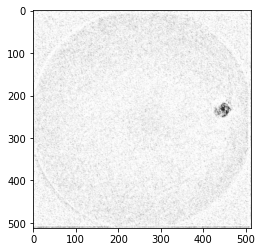

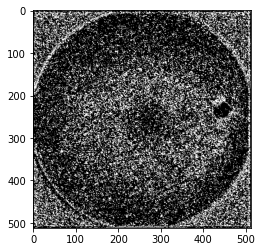

In [10]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)